In [1]:
import pathlib
import warnings
import warnings
warnings.filterwarnings('ignore')
import os

import sys
sys.path.append('../code/')

# Third-party
import astropy.coordinates as coord
import astropy.table as at
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
from numpy.lib.recfunctions import stack_arrays
from scipy.ndimage.filters import gaussian_filter
%matplotlib inline
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import InterpolatedUnivariateSpline, UnivariateSpline, interp1d
import pandas as pd

import gala.coordinates as gc
import gala.dynamics as gd
from pyia import GaiaData
from astroquery.gaia import Gaia
from astropy.table import Table
import read_mist_models

In [2]:
def plot_pretty(dpi=175, fontsize=15, labelsize=15, figsize=(10, 8), tex=True):
    # import pyplot and set some parameters to make plots prettier
    plt.rc('savefig', dpi=dpi)
    plt.rc('text', usetex=tex)
    plt.rc('font', size=fontsize)
    plt.rc('xtick.major', pad=1)
    plt.rc('xtick.minor', pad=1)
    plt.rc('ytick.major', pad=1)
    plt.rc('ytick.minor', pad=1)
    plt.rc('figure', figsize=figsize)
    mpl.rcParams['xtick.labelsize'] = labelsize
    mpl.rcParams['ytick.labelsize'] = labelsize
    mpl.rcParams.update({'figure.autolayout': False})
    
plot_pretty(fontsize=20, labelsize=20)

In [3]:
gaia = GaiaData('../data/gd1_ps1_with_basic_masks_thin.fits')
g = gaia

In [4]:
track = np.load('../data/gd1_track.npy')
phi1_ = np.load('../data/phi1_stream_from_pm_model.npy')

from scipy.interpolate import UnivariateSpline
#phi1_ = gaia[gaia.phi1.argsort()].phi1
phi2_spline = UnivariateSpline(phi1_, track, k=5)
phi1_trace = np.linspace(-100, 20, 30)
phi2_trace = phi2_spline(phi1_trace)

stream_top = np.vstack([phi1_trace, phi2_trace + 2]).T #can't go lower than this, spur is aabout 1.25 above track
stream_bottom = np.vstack([phi1_trace, phi2_trace - 2]).T
gd1_poly = np.vstack((stream_top, stream_bottom[::-1]))
gd1_phi_path = mpl.path.Path(gd1_poly)

offstream_above_top = np.vstack([phi1_trace, phi2_trace + 3]).T
offstream_above_bottom = np.vstack([phi1_trace, phi2_trace + 2]).T
ctl_poly1 = np.vstack((offstream_above_top, offstream_above_bottom[::-1]))

offstream_below_top =np.vstack([phi1_trace,  phi2_trace-2]).T
offstream_below_bottom = np.vstack([phi1_trace, phi2_trace-3]).T
ctl_poly2 = np.vstack((offstream_below_top, offstream_below_bottom[::-1]))

ctl_phi_path = [mpl.path.Path(ctl_poly1),
                mpl.path.Path(ctl_poly2)]

(-16.0, 2.0)

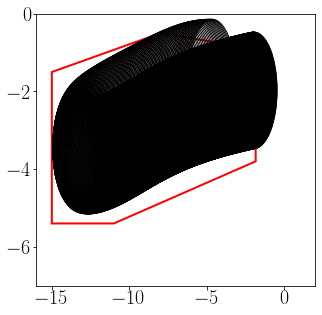

In [5]:
pm_polygon = np.array([[-15, -5.4],
                       [-15, -1.5],
                       [-8, -0.5],
                       [-1.85, -0.9],
                       [-1.85, -3.8],
                       [-11, -5.4]])

phi1_stream_pm_model = np.load('../data/phi1_stream_from_pm_model.npy')
stream_pm10 = np.load('../data/true_pm1_from_model.npy')
stream_pm20 = np.load('../data/true_pm2_from_model.npy')

pp = mpl.patches.Polygon(pm_polygon, 
                         facecolor='none',edgecolor='r', linewidth=2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.add_patch(pp)
for i in np.arange(0, len(stream_pm10), 1000):
    draw_circle = plt.Circle((stream_pm10[i][0], stream_pm20[i][0]), 1.5, fill=False)
    circle = mpl.path.Path.circle(center=(stream_pm10[i][0],stream_pm20[i][0]), radius = 0.5)
    ax.add_artist(draw_circle)

ax.set_ylim(-7,0)
ax.set_xlim(-16,2)

In [28]:
gaia = GaiaData('../data/gd1_gaia_ps1_all.fits')
gaia = gaia[np.isfinite(gaia.parallax) & (gaia.parallax > 0)]
dist = gaia.get_distance(min_parallax=1e-3*u.mas)
c = gaia.get_skycoord(distance=dist)
stream_coord = c.transform_to(gc.GD1)
pm2_0 = stream_coord.pm_phi2
gaia = gaia[np.isfinite(pm2_0)]
dist = gaia.get_distance(min_parallax=1e-3*u.mas)
c = gaia.get_skycoord(distance=dist)
stream_coord = c.transform_to(gc.GD1)
phi1_0 = stream_coord.phi1.degree

In [29]:
gaia.data

source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,visibility_periods_used,phot_g_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_mag,phot_bp_mean_flux_over_error,phot_rp_mean_mag,phot_rp_mean_flux_over_error,phot_bp_rp_excess_factor,astrometric_chi2_al,astrometric_n_good_obs_al,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr,sep_arcsec,g_0,r_0,i_0,z_0,y_0
int64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,int64,float64,float64,int16,int16,int16,int16,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
576460962757594880,135.01388149124543,0.04003546808612499,0.15212645688986826,0.07293815,-2.4026666900853497,0.0805955,1.0708832515607725,0.055787522,-0.044175282,-0.10271678,-0.14675654,0.12935668,-0.0987611,0.03582275,0.26600042,-0.15569185,-0.15320487,15,17.013802,1839.251,17.32732,192.39294,16.541967,288.52054,1.1933763,470.39096,433,108041350139168489,135.01388239,0.04003478,66,14,7,20,10,15,17.361099243164062,17.003299713134766,16.89780044555664,16.869800567626953,16.834400177001953,0.004521999973803759,0.0050050001591444016,0.0033950000070035458,0.0043310001492500305,0.004792000167071819,0.004074878607050538,17.261706091463566,16.932138979434967,16.84509574994445,16.828376308083534,16.80033953487873
576461237636292992,134.99321923793616,0.05574099738206133,0.22231422516696706,0.34323043,-2.7992308201437757,0.4012754,-0.2888012404676138,0.28464782,-0.023814311,-0.17939624,-0.19063124,0.1289148,-0.13367265,0.014559557,0.25057778,-0.18517569,-0.16375042,15,19.555357,356.47708,19.817595,23.368124,19.121157,31.908997,1.1975086,390.11957,400,108061349932557348,134.99322081,0.05574051,41,8,8,10,4,11,19.886999130249023,19.55820083618164,19.432600021362305,19.427600860595703,19.31999969482422,0.008204000070691109,0.00949000008404255,0.012395000085234642,0.025801999494433403,0.04158399999141693,0.00592517091880255,19.785674288868904,19.48565711081028,19.378871019929647,19.385371528565884,19.2852770909667
576461302059243008,135.04814535677022,0.04744551983646838,0.22624301324170015,0.16557306,-0.9119116363239348,0.18146275,-0.66478895347824,0.12800759,-0.06615837,-0.1512907,-0.061596025,0.1133974,-0.04050068,-0.036425423,0.24516608,-0.086194195,-0.14704914,15,18.428467,807.2721,18.680258,59.00202,18.014496,46.374775,1.1914258,341.80518,389,108051350481717378,135.04814702,0.04744477,75,10,10,20,18,17,18.721799850463867,18.436399459838867,18.341999053955078,18.349000930786133,18.29319953918457,0.009690999984741211,0.003990999888628721,0.0053400001488626,0.00928799994289875,0.01666099950671196,0.006567988713473633,18.62444857507944,18.36670061200857,18.290377095341682,18.308427665382624,18.259838618338108
576461370779014144,135.03485970439323,0.0572434236053661,0.3082438221779312,0.18085869,-2.8608634062850586,0.20063995,-5.723706284822912,0.13539675,-0.03989332,-0.1506807,-0.1412491,0.14523412,-0.09097728,-0.013390955,0.2805282,-0.17040057,-0.12405243,15,18.56232,713.04297,18.873882,30.27692,18.094776,66.53292,1.1917948,477.65207,427,108061350348969148,135.0348622,0.057244,74,14,10,22,13,15,18.905399322509766,18.554500579833984,18.432600021362305,18.42449951171875,18.391599655151367,0.0071749999187886715,0.0018439999548718333,0.006128999870270491,0.00966500025242567,0.014209999702870846,0.009220694049568372,18.806585028767586,18.48375428467989,18.380202278494835,18.38331650570035,18.357737381011248
576461680016663168,135.01799190942967,0.07984291407597655,0.40469111312284745,0.192917

Reading in: ../data/isochrones/MIST_PS_iso_feh_-1.7_vrot0.iso.cmd


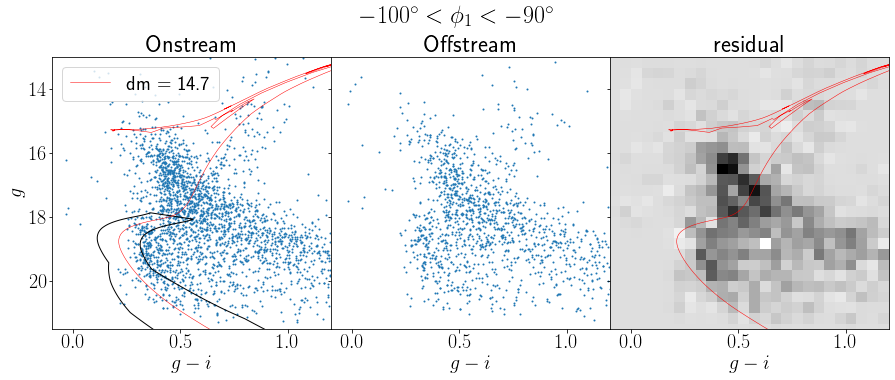

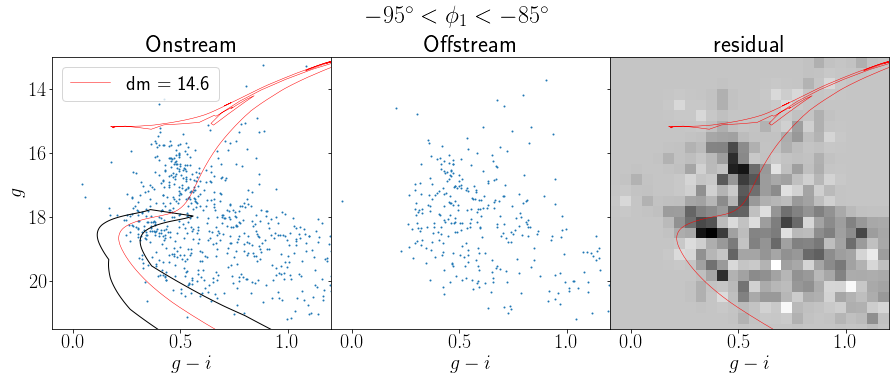

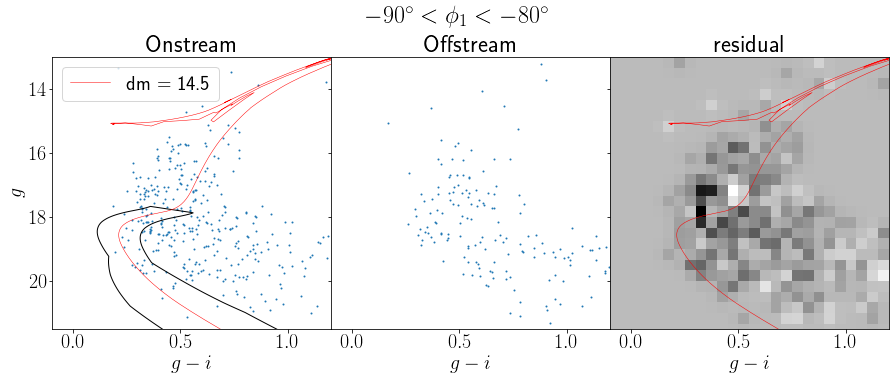

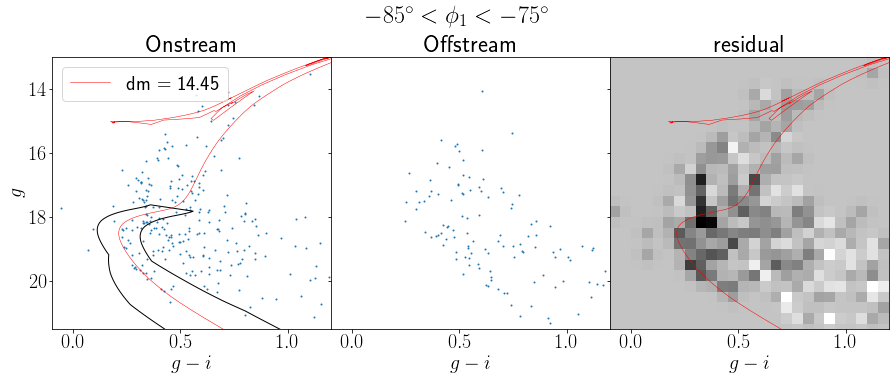

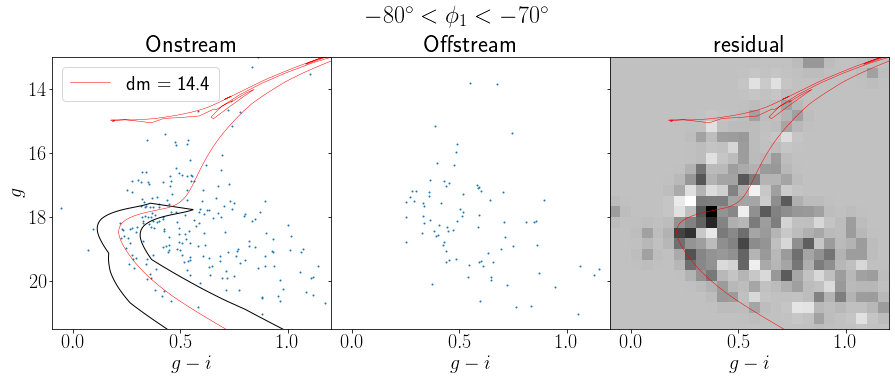

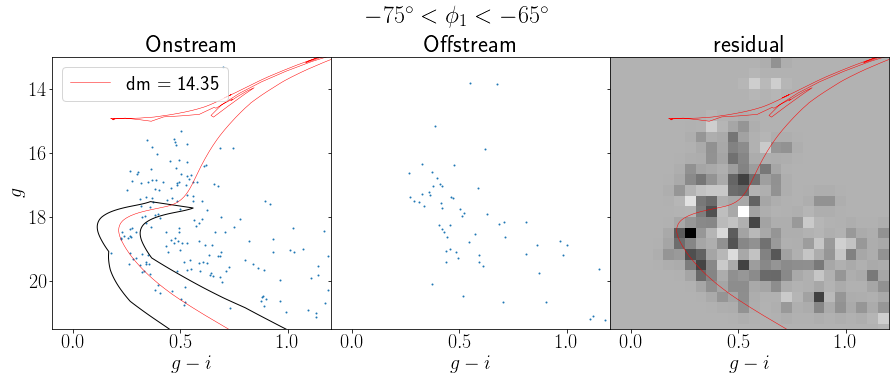

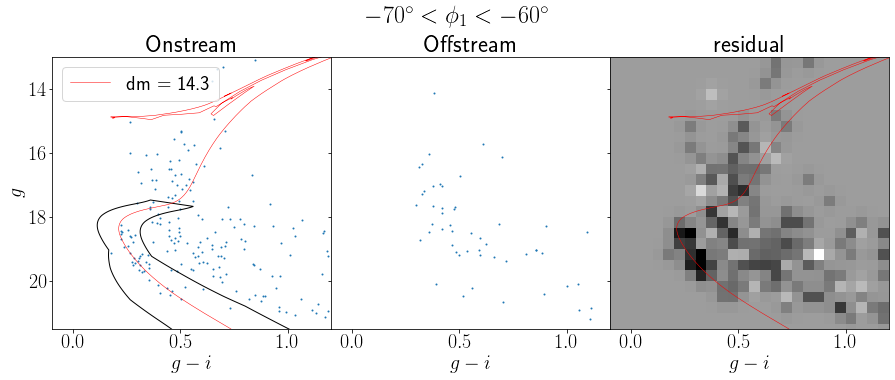

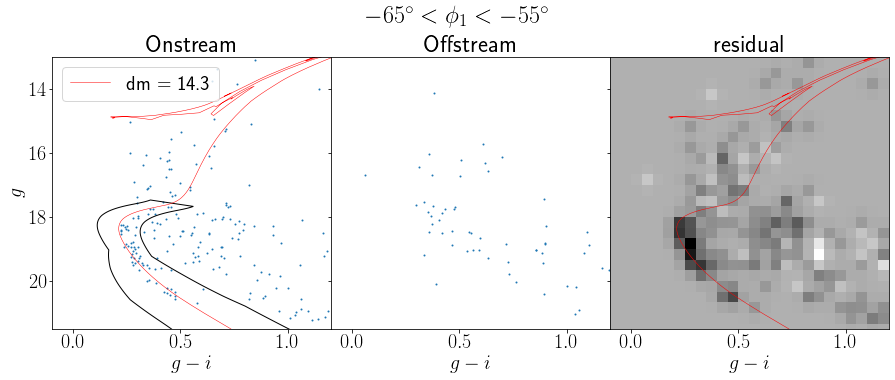

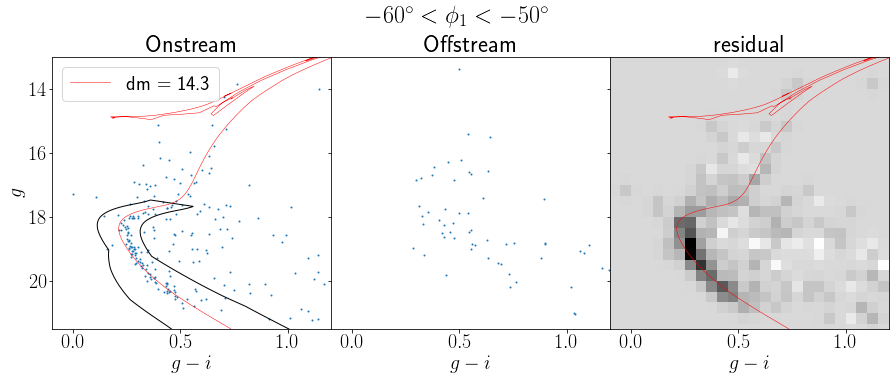

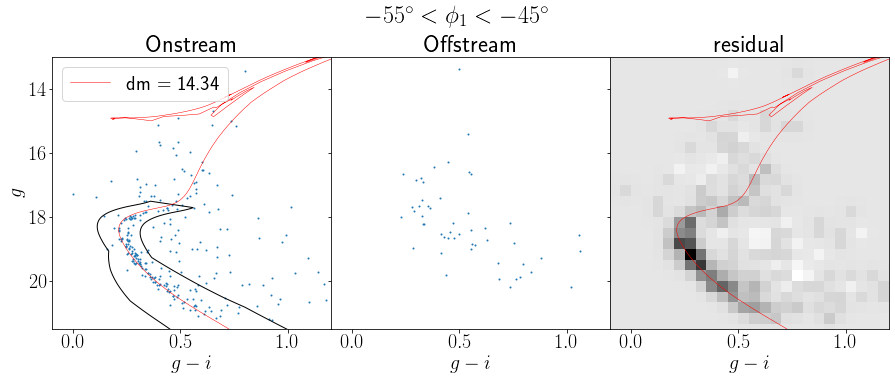

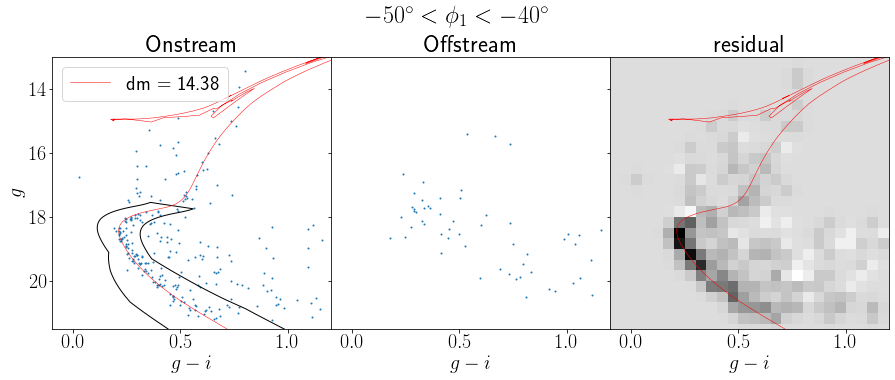

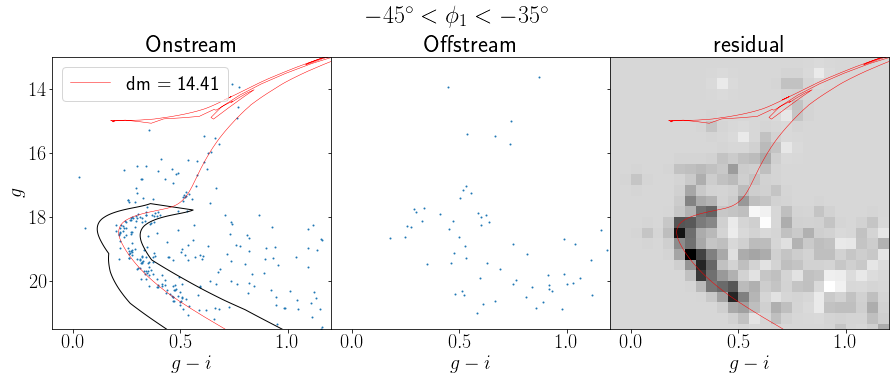

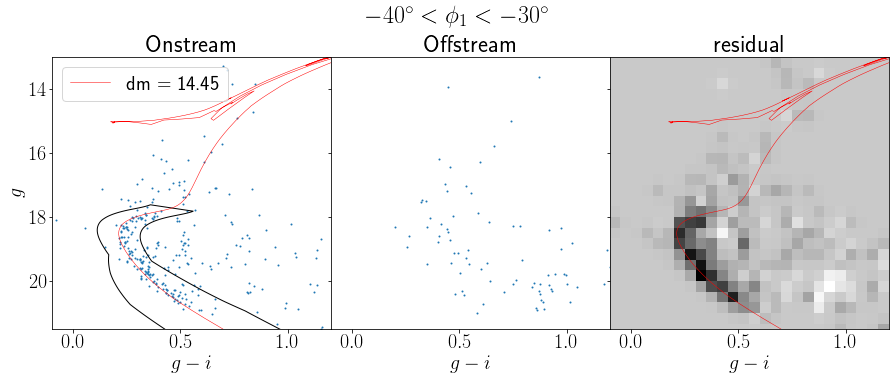

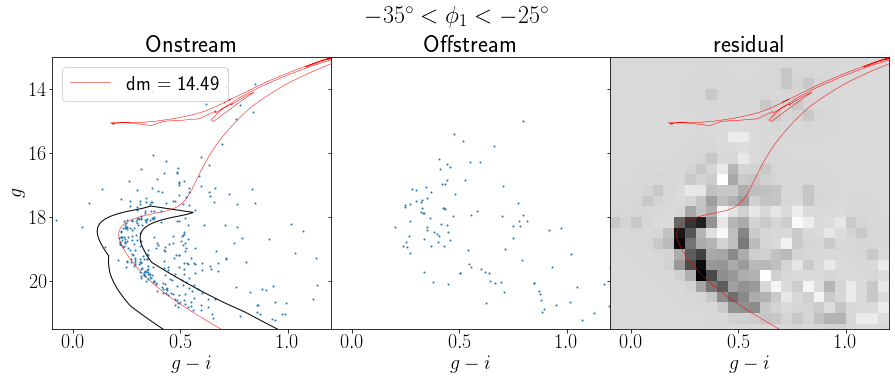

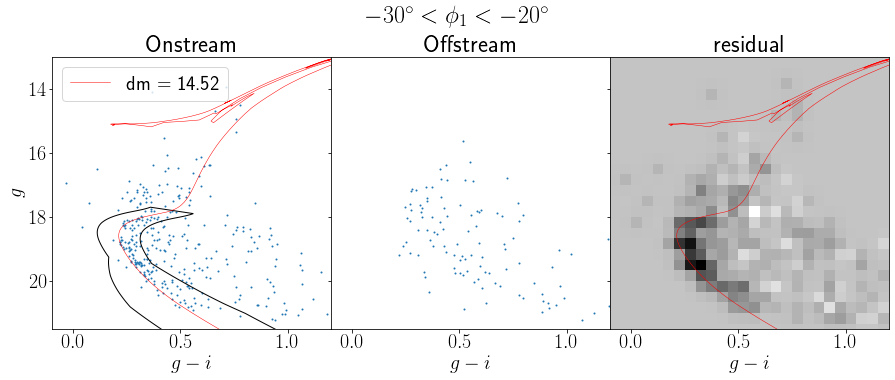

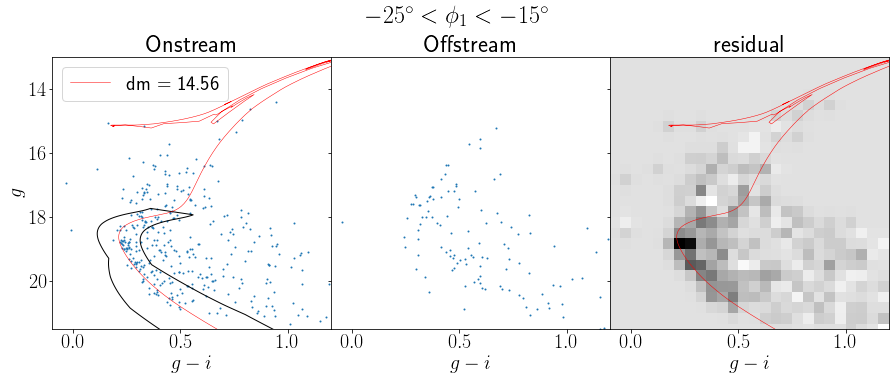

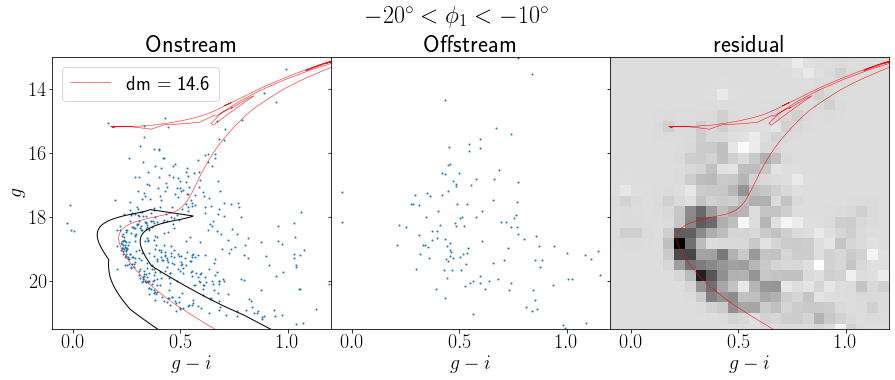

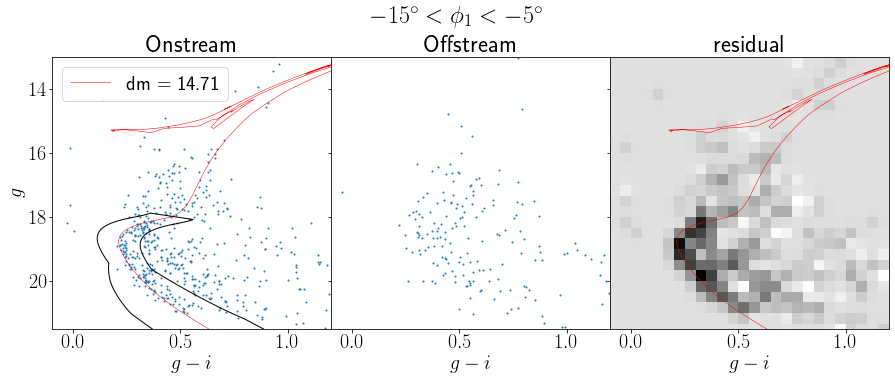

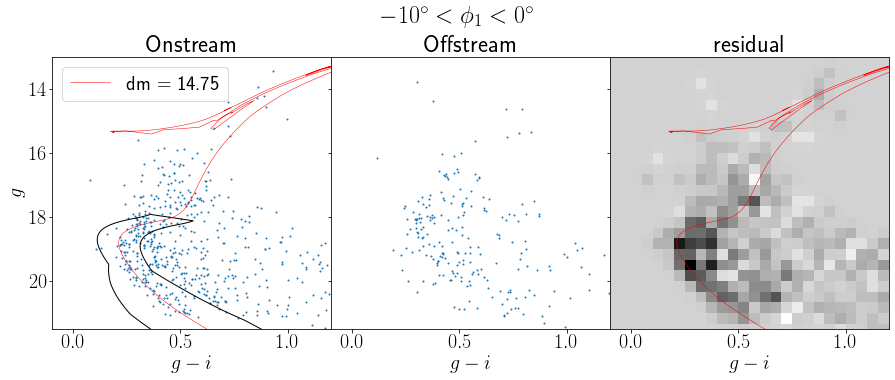

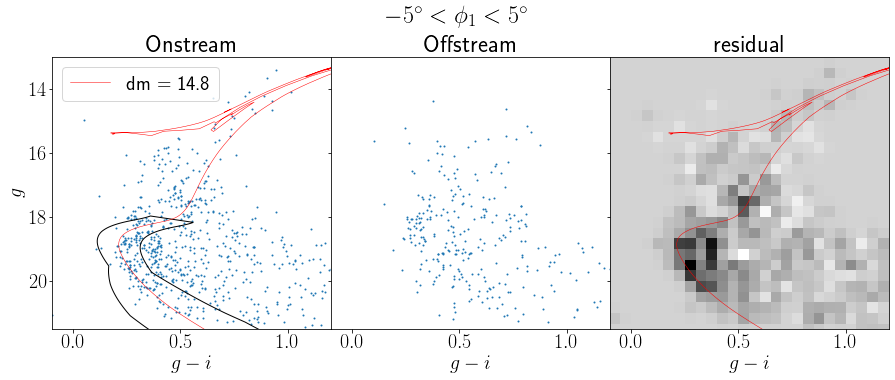

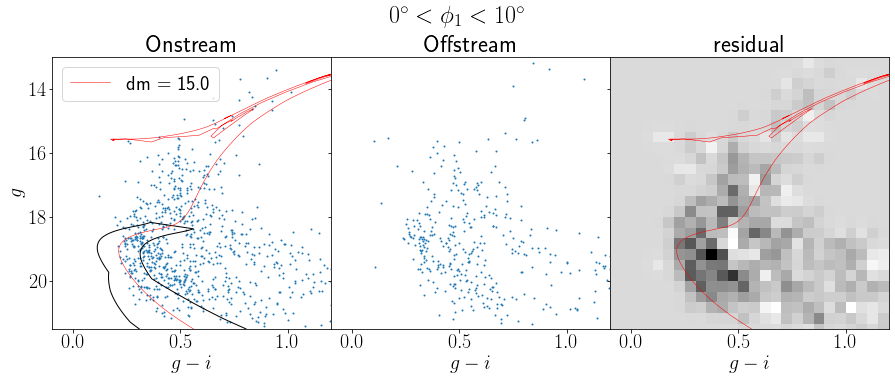

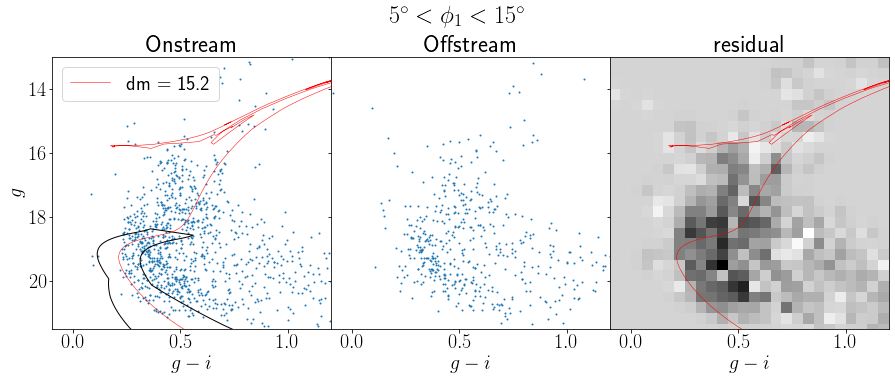

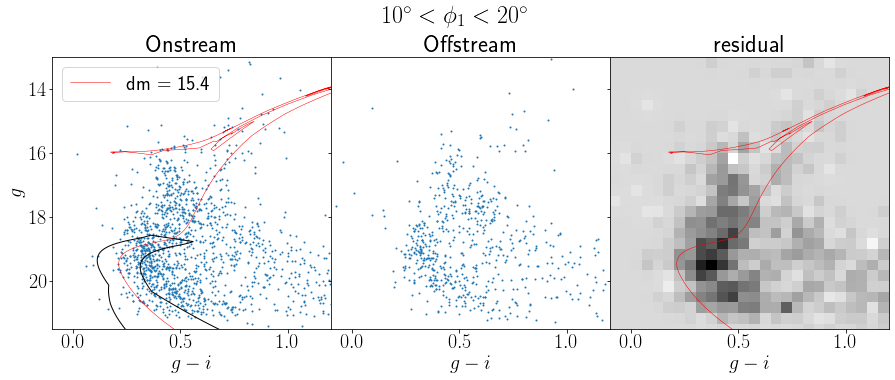

In [34]:
sections = np.arange(-100,15,5)
#Load in MIST isochrone:
feh_sel, age_select = -1.7, 13
iso_file = '../data/isochrones/MIST_PS_iso_feh_{}_vrot0.iso.cmd'.format(feh_sel)
isocmd = read_mist_models.ISOCMD(iso_file)

age_sel = isocmd.age_index(age_select*10**9)
gmag = isocmd.isocmds[age_sel]['PS_g']
imag = isocmd.isocmds[age_sel]['PS_i']
gi_color = gmag-imag

dm = np.concatenate([[14.7, 14.6, 14.5, 14.45, 14.4, 14.35, 14.3, 14.3], 
                     np.linspace(14.3, 14.6, 9), 
                     [14.71, 14.75, 14.8, 15, 15.2, 15.4]])

all_final = at.Table()

for i in range(len(sections)):
    left = int(sections[i])
    right = left+10
    g = gaia[(phi1_0 < right) & (phi1_0 > left)]
    
    dist = g.get_distance(min_parallax=1e-3*u.mas)
    c = g.get_skycoord(distance=dist)
    stream_coord = c.transform_to(gc.GD1)
    phi1 = stream_coord.phi1.degree
    phi2 = stream_coord.phi2.degree
    pm1 = stream_coord.pm_phi1_cosphi2
    pm2 = stream_coord.pm_phi2
    
    
    indices = np.where((phi1_stream_pm_model < right) & (phi1_stream_pm_model > left))[0]
    pm1_ave = np.mean(stream_pm10[indices])
    pm2_ave = np.mean(stream_pm20[indices])

    circle = mpl.path.Path.circle(center=(pm1_ave,pm2_ave), radius = 1.5)
    pmcut = circle.contains_points(np.stack((pm1, pm2)).T)
    gcut = g[pmcut]

    phi1_cut = phi1[pmcut]
    phi2_cut = phi2[pmcut]
    pm1_cut = pm1[pmcut]
    pm2_cut = pm2[pmcut]

    X = np.stack((phi1_cut, phi2_cut)).T
    sky_gd1_mask = gd1_phi_path.contains_points(X)
    sky_ctl_mask = ctl_phi_path[0].contains_points(X) | ctl_phi_path[1].contains_points(X)
    
    
    pm_polygon = np.array([[-15, -5.4],
                       [-15, -1.5],
                       [-8, -0.5],
                       [-1.85, -0.9],
                       [-1.85, -3.8],
                       [-11, -5.4]])
    pp = mpl.patches.Polygon(pm_polygon, 
                         facecolor='none',edgecolor='k', linewidth=2)
    pm_points = np.vstack((pm1, pm2)).T
    pm_mask = pp.get_path().contains_points(pm_points)
    
    width_changes = np.concatenate([0.6*np.linspace(1, 1/6, 150), 0.1*np.ones(70)])
    
    iso_contour = np.concatenate((np.vstack([gi_color[:220] + width_changes, gmag[:220]+dm[i] + 0.1]).T,
                                  np.flip(np.vstack([gi_color[:220] - width_changes, gmag[:220]+dm[i] - 0.1]).T, axis = 0)))

    cc_iso = mpl.patches.Polygon(iso_contour, facecolor='none',edgecolor='k', linewidth=1)
    
    cm_points_iso = np.vstack([g.g_0-g.i_0, g.g_0]).T
    cm_mask_iso = cc_iso.get_path().contains_points(cm_points_iso)
    
    final_phi1_mask = (phi1 > -100) & (phi1 < 20)

    final_t = g.data[final_phi1_mask]
    final_t['pm_mask'] = pm_mask[final_phi1_mask]
    final_t['gi_cmd_mask'] = cm_mask_iso[final_phi1_mask]

    final_t['phi1'] = phi1[final_phi1_mask]
    final_t['phi2'] = phi2[final_phi1_mask]

    final_t['pm_phi1_cosphi2'] = pm1[final_phi1_mask]
    final_t['pm_phi2'] = pm2[final_phi1_mask]

    all_final = at.vstack([all_final, final_t])
    
    fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=True)

    axs[0].scatter(gcut.g_0[sky_gd1_mask] - gcut.i_0[sky_gd1_mask], gcut.g_0[sky_gd1_mask],s=1)
    axs[0].plot(gi_color, gmag+dm[i], lw = 0.5, c='r', label = 'dm = {}'.format(np.around(dm[i], 2)))
    axs[0].add_patch(cc_iso)
    axs[0].set_xlim(-0.1,1.2); axs[0].set_ylim(21.5,13)
    axs[0].set_xlabel(r'$g - i$'); axs[0].set_ylabel(r'$g$')
    axs[0].set_title('Onstream')
    axs[0].legend()

    axs[1].scatter(gcut.g_0[sky_ctl_mask] - gcut.i_0[sky_ctl_mask], gcut.g_0[sky_ctl_mask],s=1)
    axs[1].set_xlim(-0.1,1.2); axs[0].set_ylim(21.5,13)
    axs[1].set_xlabel(r'$g - i$')
    axs[1].set_title('Offstream')

    H_on, bx, by = np.histogram2d(gcut.g_0[sky_gd1_mask] - gcut.i_0[sky_gd1_mask], gcut.g_0[sky_gd1_mask],
                                  bins = [26,27], range=[[-0.1, 1.2], [13, 22]])
    H_off, bx, by = np.histogram2d(gcut.g_0[sky_ctl_mask] - gcut.i_0[sky_ctl_mask], gcut.g_0[sky_ctl_mask],
                                 bins = [26,27], range=[[-0.1, 1.2], [13, 22]])
    smooth = gaussian_filter(H_on - H_off, 0.5)
    axs[2].pcolormesh(bx, by, smooth.T, cmap = 'gray_r')
    axs[2].plot(gi_color, gmag+dm[i], lw = 0.5, c='r')
    axs[2].set_xlim(-0.1,1.2); axs[0].set_ylim(21.5,13)
    axs[2].set_xlabel(r'$g - i$')
    axs[2].set_title('residual')
    plt.suptitle(r'${}^\circ < \phi_1 < {}^\circ $'.format(left, left+10), y=1.02)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

Text(0.5, 1.0, 'Approximate Distance Modulus')

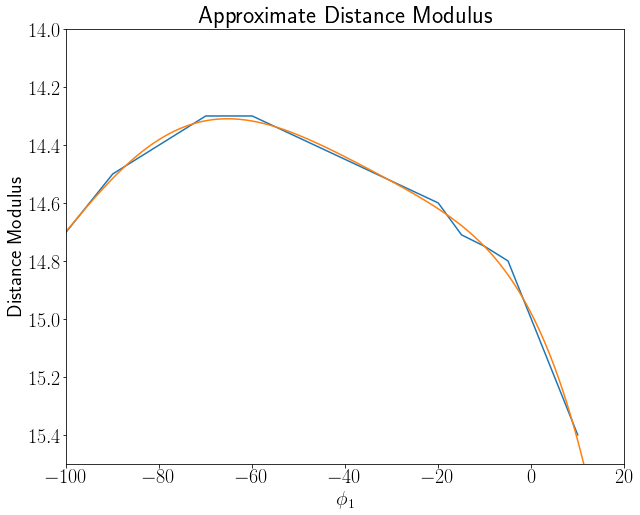

In [35]:
plt.plot(sections, dm)
spline_dm = UnivariateSpline(sections, dm, k=5)
plt.plot(phi1_stream_pm_model, spline_dm(phi1_stream_pm_model))
plt.xlim(-100, 20)
plt.ylim(15.5, 14)
plt.xlabel(r'$\phi_1$')
plt.ylabel('Distance Modulus')
plt.title('Approximate Distance Modulus')

In [36]:
arr, ind = np.unique(all_final['phi1'], return_index=True)

In [37]:
all_final = all_final[ind]

In [39]:
all_final.write('../data/gd1_ps1_with_basic_masks_thin.fits', overwrite=True)

In [40]:
g = GaiaData('../data/gd1_ps1_with_basic_masks_thin.fits')
g

<GaiaData: 3675484 rows>

386801


(-0.1, 1.2)

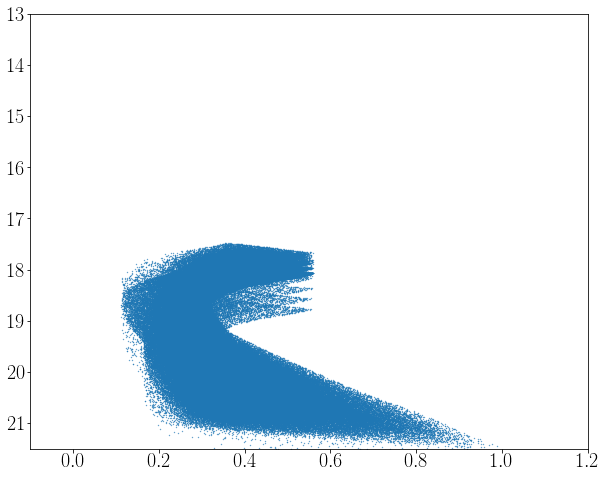

In [41]:
test = g[g.gi_cmd_mask]
print(len(test))
plt.scatter(test['g_0'] - test['i_0'], test['g_0'], s = 0.1)
plt.ylim(21.5, 13)
plt.xlim(-0.1, 1.2)

guess = (-7.4, -3.3)
actual = (-6.994330170439262, -3.4112608517760807)


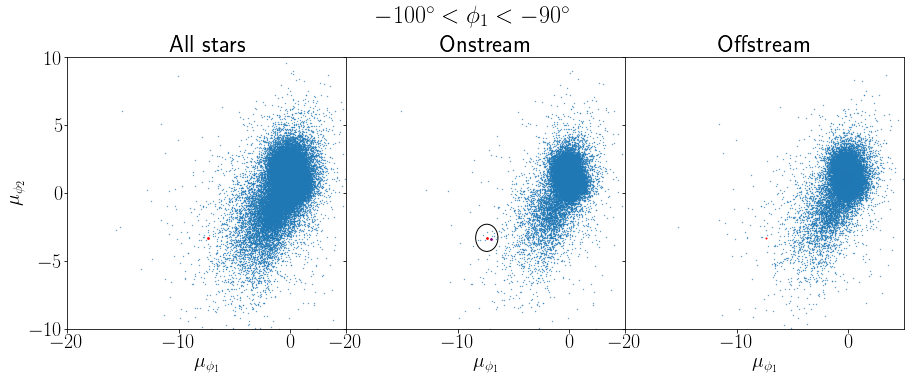

guess = (-9.5, -3.5)
actual = (-9.072028777162062, -3.907376993704334)


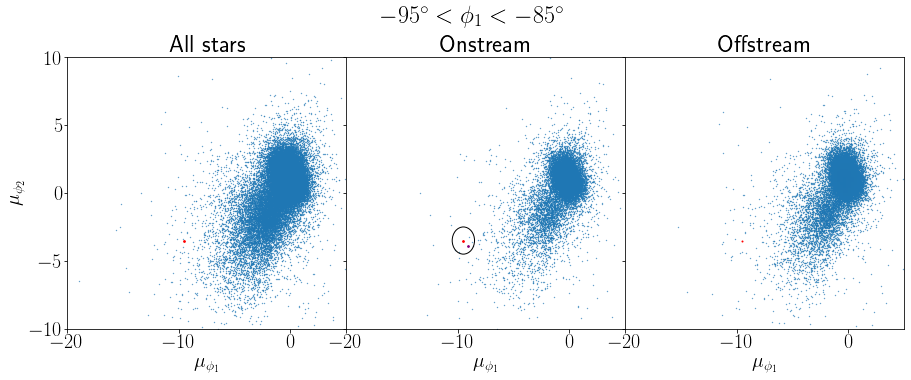

guess = (-10.5, -3.7)
actual = (-9.814859641694518, -3.6844019611474272)


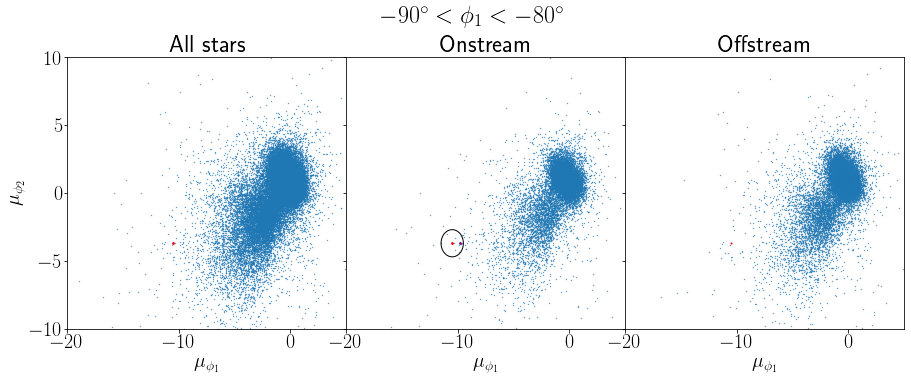

guess = (-12, -3.7)
actual = (-10.981391651049849, -3.178884551249662)


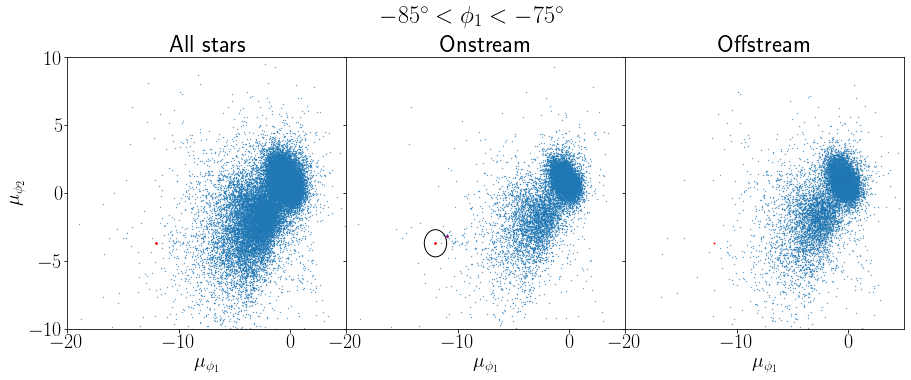

guess = (-13, -3.7)
actual = (-12.647387437179262, -4.114343257018126)


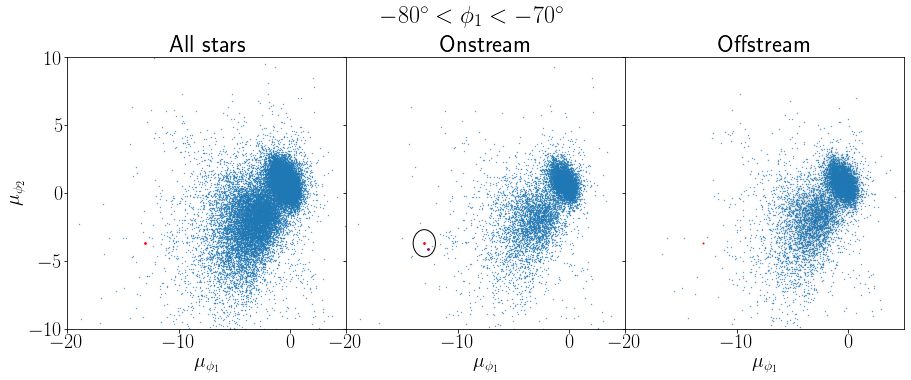

guess = (-13.3, -3.5)
actual = (-12.29789761754002, -3.825189878002303)


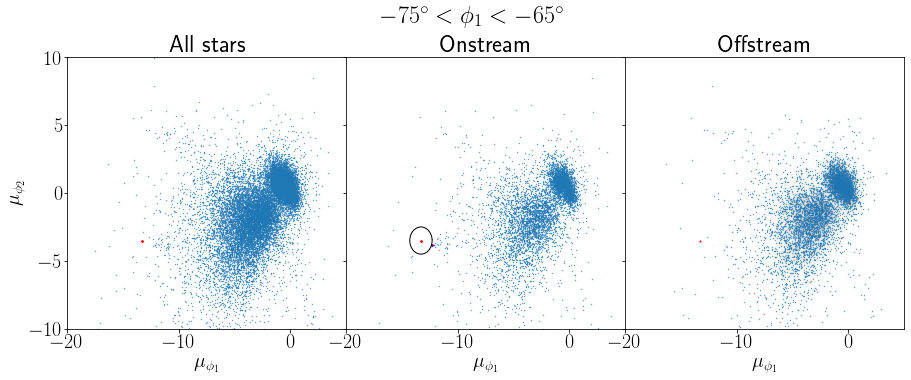

guess = (-13, -3.2)
actual = (-12.452699520712912, -3.7430579911126176)


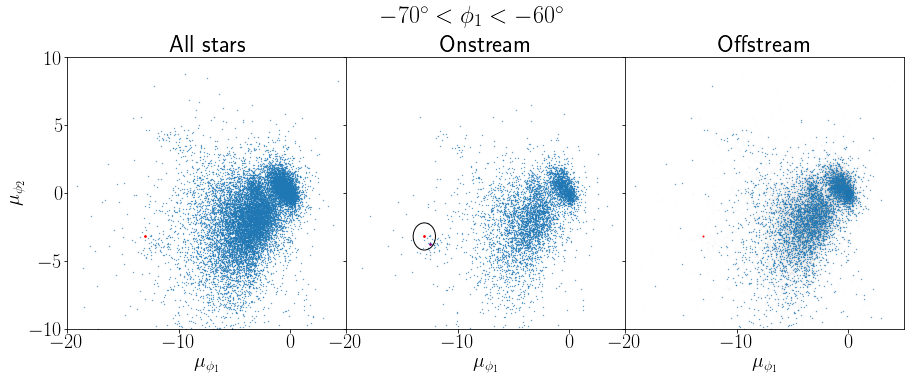

guess = (-12.2, -3)
actual = (-12.499950895845771, -3.545056997255201)


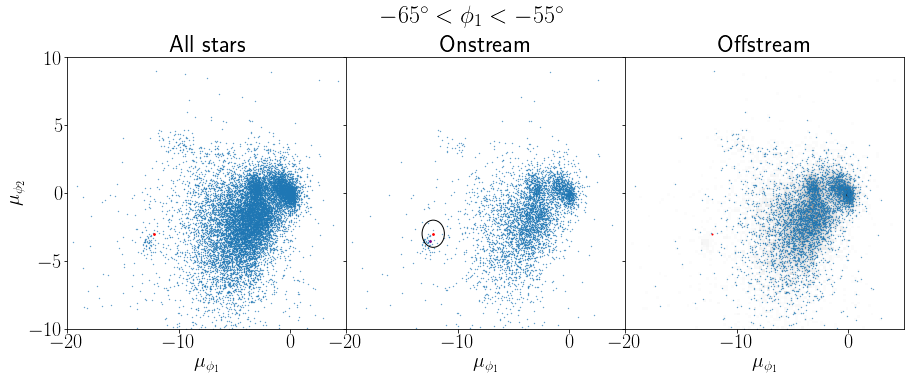

guess = (-10.5, -2.5)
actual = (-10.098697256802007, -2.4766792071210437)


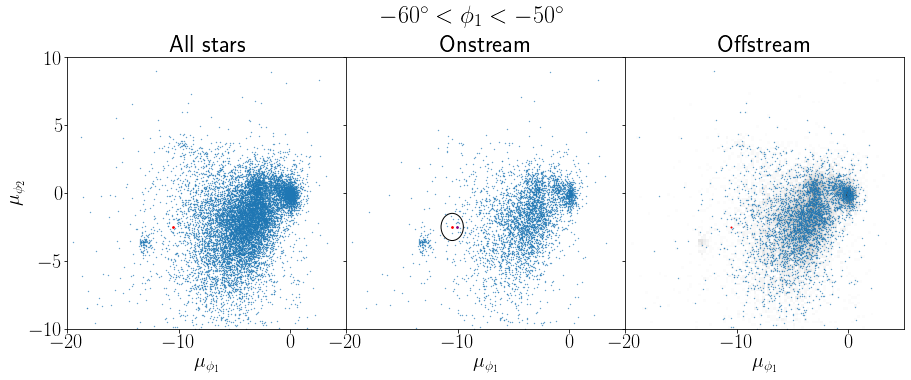

guess = (-9, -2.3)
actual = (-8.823200010750586, -2.303245863501525)


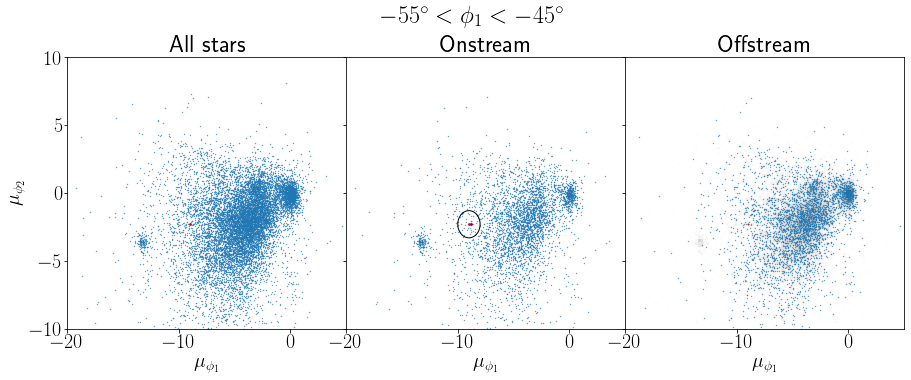

guess = (-8, -2)
actual = (-7.709323737199462, -2.1481834409996483)


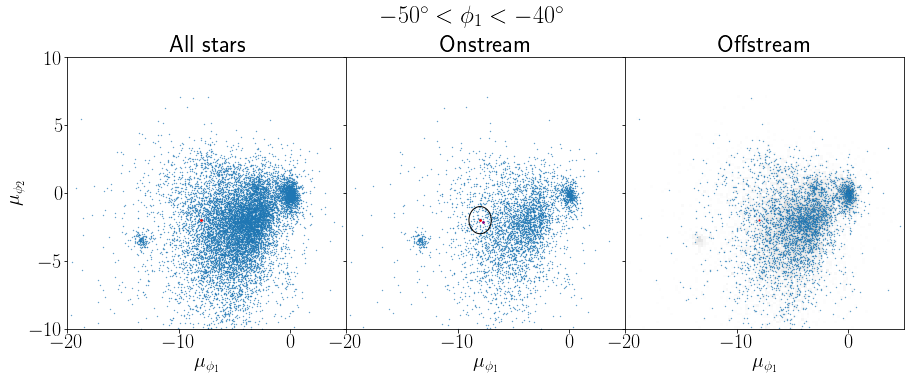

guess = (-7, -2)
actual = (-6.823527834339384, -2.113320707751176)


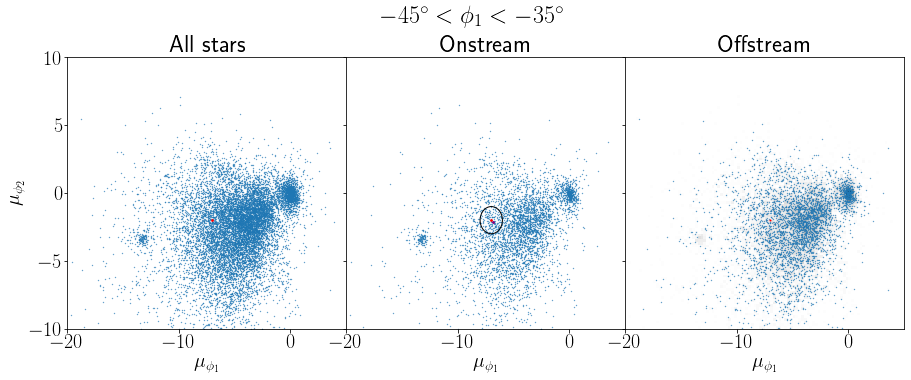

IndexError: list index out of range

In [10]:
pm1_means   = [-7.4, -9.5, -10.5, -12 , -13 , -13.3, -13 , -12.2, -10.5, -9  , -8, -7]
pm2_means   = [-3.3, -3.5, -3.7 , -3.7, -3.7, -3.5 , -3.2, -3   , -2.5 , -2.3, -2, -2]
phi1_for_pm = [-95 , -85 , -75  , -65 , -55 , -45  , -35 , -25  , -15  , -5  , 5 , 15]

sections = np.arange(-100,20,5)

for i in range(len(sections)):
    left = int(sections[i])
    right = left+10
    gaia = GaiaData('../data/gd1_ps1_with_basic_masks_wide.fits')
    g = gaia[np.isfinite(gaia.parallax) & (gaia.parallax > 0) & np.isfinite(gaia.pm_phi2) & 
             (gaia.phi1 < right) & (gaia.phi1 > left)]

    #create polygon for color cut
    poly = mpl.path.Path([[0.7, 21], [1.1, 21], [0.7, 18.5], [0.7, 17.8], [0.5, 17.8], [0.5, 19]])
    cm = np.vstack([g.phot_bp_mean_mag-g.phot_rp_mean_mag, g.phot_g_mean_mag]).T
    idx = poly.contains_points(cm)
    g_ccut = g[idx]

    dist = g_ccut.get_distance(min_parallax=1e-3*u.mas)
    c = g_ccut.get_skycoord(distance=dist)

    stream_coord = c.transform_to(gc.GD1)
    phi1 = stream_coord.phi1.degree
    phi2 = stream_coord.phi2.degree
    pm1 = stream_coord.pm_phi1_cosphi2
    pm2 = stream_coord.pm_phi2

    X = np.stack((phi1, phi2)).T
    sky_gd1_mask = gd1_phi_path.contains_points(X)
    sky_ctl_mask = ctl_phi_path[0].contains_points(X) | ctl_phi_path[1].contains_points(X)
    
    onstream_pm1, offstream_pm1 = pm1[sky_gd1_mask], pm1[sky_ctl_mask]
    onstream_pm2, offstream_pm2 = pm2[sky_gd1_mask], pm2[sky_ctl_mask]

    draw_circle = plt.Circle((pm1_means[i], pm2_means[i]), 1, fill=False)
    circle = mpl.path.Path.circle(center=(pm1_means[i],pm2_means[i]), radius = 1.5)
    pm_cluster = circle.contains_points(np.stack((onstream_pm1, onstream_pm2)).T)

    
    mean_pm1 = np.mean(onstream_pm1[pm_cluster])
    mean_pm2 = np.mean(onstream_pm2[pm_cluster])
    print('guess = ({}, {})'.format(pm1_means[i],pm2_means[i]))
    print('actual = ({}, {})'.format(mean_pm1.value, mean_pm2.value))
    
    fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=True)
    h,xbins,ybins,im = plt.hist2d(pm1.value[~np.isnan(pm1)], pm2.value[~np.isnan(pm2)], 
               range=[[-20, 5], [-10, 10]], bins = 100, cmap='gray_r')

    axs[0].scatter(pm1, pm2,s=0.1)
    axs[0].scatter(pm1_means[i], pm2_means[i], c='r', s = 3)
    axs[0].set_xlim(-20,5); axs[0].set_ylim(-10,10)
    axs[0].set_xlabel(r'$\mu_{\phi_1}$'); axs[0].set_ylabel(r'$\mu_{\phi_2}$')
    axs[0].set_title('All stars')

    axs[1].scatter(onstream_pm1, onstream_pm2, s=0.1)
    axs[1].scatter(pm1_means[i], pm2_means[i], c='r', s = 3)
    axs[1].scatter(mean_pm1.value, mean_pm2.value, c='purple', s = 3)
    axs[1].add_artist(draw_circle)
    axs[1].set_xlim(-20,5); axs[1].set_ylim(-10,10)
    axs[1].set_xlabel(r'$\mu_{\phi_1}$')
    axs[1].set_title('Onstream')

    axs[2].scatter(offstream_pm1, offstream_pm2, s=0.1)
    axs[2].scatter(pm1_means[i], pm2_means[i], c='r', s = 1)
    axs[2].set_xlim(-20,5); axs[2].set_ylim(-10,10)
    axs[2].set_xlabel(r'$\mu_{\phi_1}$')
    axs[2].set_title('Offstream')
    plt.suptitle(r'${}^\circ < \phi_1 < {}^\circ $'.format(left, left+10), y=1.02)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    pm1_means[i], pm2_means[i] = mean_pm1.value, mean_pm2.value

In [6]:
print(pm1_means)
print(pm2_means)

[-7.080298352845432, -9.323776057026052, -10.49901320327918, -12.087734770495718, -13.071472932503166, -13.317883027489403, -13.077529778684564, -12.238851790201116, -10.493499948754906, -8.901566351641288, -7.7900421555784565, -6.778428082233351]
[-3.5031714454749467, -3.6184905220613204, -3.6664552055549247, -3.800023274262645, -3.740613853308287, -3.5660511427908976, -3.229083227180735, -2.9048303400383766, -2.562123644862452, -2.1941935673352453, -1.9760915921461648, -1.9658006008622226]


In [42]:
a,b,c = 0.0005, 0.07, -2

def quad(xs):
    return a*xs**2+b*xs+c

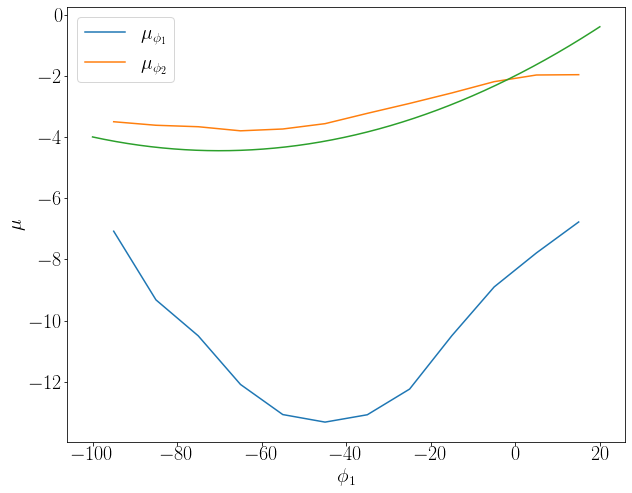

In [43]:
xs=np.linspace(-100,20, 1000)
plt.figure()
plt.plot(phi1_for_pm, pm1_means, label=r'$\mu_{\phi_1}$')
plt.plot(phi1_for_pm, pm2_means, label=r'$\mu_{\phi_2}$')
plt.plot(xs, quad(xs))
plt.legend()
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\mu$')
plt.show()